# CS221 Project
**Dawn Finzi and Mona Rosenke**

In [1]:
#This notebook uses the ResNet 50 architecture and applies it to the
#the dermatoscopy dataset

In [2]:
#Import a bunch of required packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(12345)
import h5py

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
#Helper functions for later

#Plot the model training history (accuracy and loss)
def plot_model_history(model_history):
    plt.style.use('seaborn')
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

#To clean up confusion matriz 
def round_sig(f, p):
    return float(('%.' + str(p) + 'e') % f)

#Plot confusion matrix - normalizes by category based on the true labels
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.viridis):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.style.use('default')
    
    if normalize: 
        #normalize by true class b/c they vary greatly in num images
        cm = cm.astype('float')
        class_totals = cm.sum(axis=1)
        for i in range(len(classes)):
            for j in range(len(classes)):
                cm[i,j] = cm[i,j] /class_totals[i]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round_sig(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')    

In [4]:
#Import the image data from the two folders
base_skin_dir = os.path.join('..', 'data')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
#Read in the metadata

meta = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

meta['path'] = meta['image_id'].map(imageid_path_dict.get)
meta['cell_type'] = meta['dx'].map(lesion_type_dict.get) 
meta['cell_type_idx'] = pd.Categorical(meta['cell_type']).codes
meta.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
3349,HAM_0007142,ISIC_0025255,nv,follow_up,50.0,female,lower extremity,../data/HAM10000_images/ISIC_0025255.jpg,Melanocytic nevi,4
7961,HAM_0002417,ISIC_0033442,nv,histo,NaN,male,upper extremity,../data/HAM10000_images/ISIC_0033442.jpg,Melanocytic nevi,4
5029,HAM_0005923,ISIC_0031419,nv,follow_up,55.0,female,lower extremity,../data/HAM10000_images/ISIC_0031419.jpg,Melanocytic nevi,4
2095,HAM_0002609,ISIC_0029318,mel,histo,60.0,female,back,../data/HAM10000_images/ISIC_0029318.jpg,Melanoma,5
8108,HAM_0000861,ISIC_0028734,nv,histo,20.0,female,lower extremity,../data/HAM10000_images/ISIC_0028734.jpg,Melanocytic nevi,4


In [6]:
#Load in all of the images into memory - this will take a while.  
meta['image'] = meta['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

### Setup train, test and validation datasets

In [7]:
#Create x and y (drop labels from X and assign labels y)
X=meta.drop(columns=['cell_type_idx'],axis=1)
y=meta['cell_type_idx']

In [8]:
#Get train and test splits (80/20) - stratify splits!
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(X,
                                                            y,
                                                            test_size=0.20,
                                                            stratify = y)

In [9]:
#Get the images from the list
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

In [10]:
#Subtract mean and normalize images (to reduce effect of illumination diffs)
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [11]:
#Convert class vectors to binary class matrices
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [12]:
#Split training data into training and validation subsets
x_train, x_validate, y_train, y_validate = train_test_split(x_train,
                                                            y_train,
                                                            test_size = 0.1,
                                                            stratify = y_train)

In [13]:
batch_size = 16
nb_classes = 7
nb_epoch = 35

In [14]:
#Data augmentation to help with overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images 
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

## ResNet 50

In [15]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential,Model,model_from_json

In [16]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6) #learning rate annealer
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('ResNet50_hmnist.csv')

In [17]:
#Define the optimizer (made LR smaller)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [18]:
#Import the ResNet 50 architecture (pre-trained on Imagenet)
resnet50=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

/usr/local/lib/python2.7/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [19]:
#Add custom layers to the end of the out of the box set up 
#(after the last activation layer)

#Inspiration for custom layer setup comes from:
#https://www.kaggle.com/arnabd2002/transferlearningwith-vgg16
customLayers=Flatten()(resnet50.output)
customLayers=Dense(1000,activation='relu')(customLayers)
customLayers=Dropout(0.20)(customLayers)
customLayers=Dense(500,activation='relu')(customLayers)
customLayers=Dropout(0.20)(customLayers)
customLayers=Dense(nb_classes,activation='softmax')(customLayers)
customResnetModel=Model(input=resnet50.input,output=customLayers)
customResnetModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/home/eshedm/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  if sys.path[0] == '':


In [20]:
customResnetModel.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [22]:
resnet50_history = customResnetModel.fit_generator(
    datagen.flow(x_train,
                 y_train,
                 batch_size=batch_size),
    epochs = nb_epoch,
    validation_data = (x_validate,
                       y_validate),
    verbose = 1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[lr_reducer, early_stopper, csv_logger]
)

Epoch 1/35
450/450 [==============================] - 3492s 8s/step - loss: 0.6903 - acc: 0.7612 - val_loss: 0.6964 - val_acc: 0.7843
Epoch 2/35
450/450 [==============================] - 3312s 7s/step - loss: 0.5153 - acc: 0.8198 - val_loss: 0.6073 - val_acc: 0.7905
Epoch 3/35
450/450 [==============================] - 3316s 7s/step - loss: 0.4255 - acc: 0.8530 - val_loss: 0.7095 - val_acc: 0.7918
Epoch 4/35
450/450 [==============================] - 3315s 7s/step - loss: 0.3983 - acc: 0.8634 - val_loss: 0.5383 - val_acc: 0.8192
Epoch 5/35
450/450 [==============================] - 3314s 7s/step - loss: 0.3527 - acc: 0.8782 - val_loss: 0.6265 - val_acc: 0.8167
Epoch 6/35
450/450 [==============================] - 3312s 7s/step - loss: 0.2480 - acc: 0.9167 - val_loss: 0.8754 - val_acc: 0.7868
Epoch 7/35
450/450 [==============================] - 3317s 7s/step - loss: 0.2274 - acc: 0.9187 - val_loss: 0.7978 - val_acc: 0.8055
Epoch 8/35
450/450 [==============================] - 3319s 7s

In [23]:
loss, accuracy = customResnetModel.evaluate(x_validate,
                                            y_validate,
                                            verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

802/802 [==============================] - 151s 188ms/step
Validation: accuracy = 0.811721  ;  loss = 0.847642


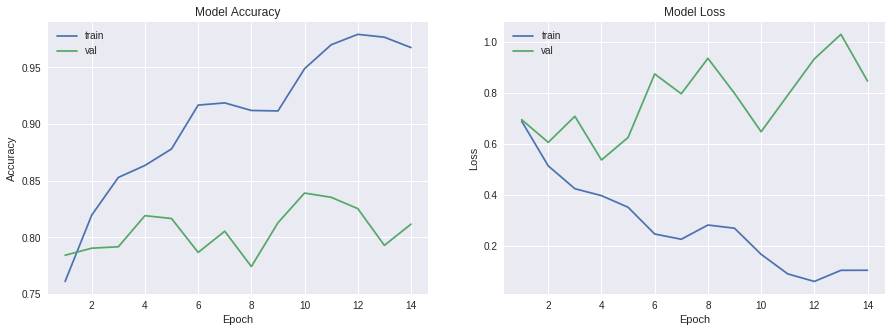

In [24]:
plot_model_history(resnet50_history)

In [25]:
#Save model for later
customResnetModel.save("resnet50_new.h5")

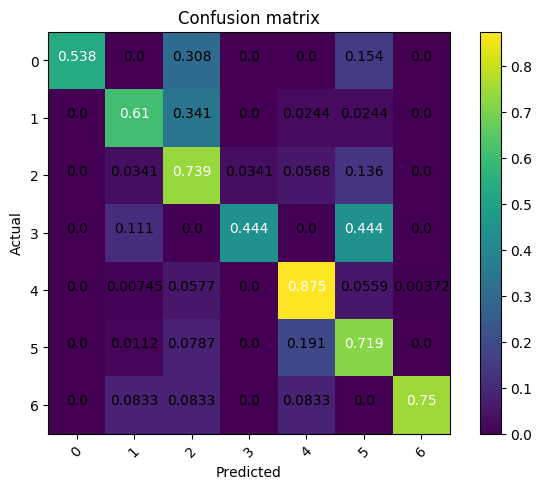

In [26]:
#Plot the confusion matrix

# Predict the values from the validation dataset
Y_pred = customResnetModel.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

In [27]:
#Let's save our training, validation and test sets 
#so that we can use them in other notebooks

hf = h5py.File('data_new.h5', 'w')

#training
hf.create_dataset('x_train', data=x_train)
hf.create_dataset('y_train', data=y_train)
#validation
hf.create_dataset('x_validate', data=x_validate)
hf.create_dataset('y_validate', data=y_validate)
#test
hf.create_dataset('x_test', data=x_test)
hf.create_dataset('y_test', data=y_test)

hf.close()

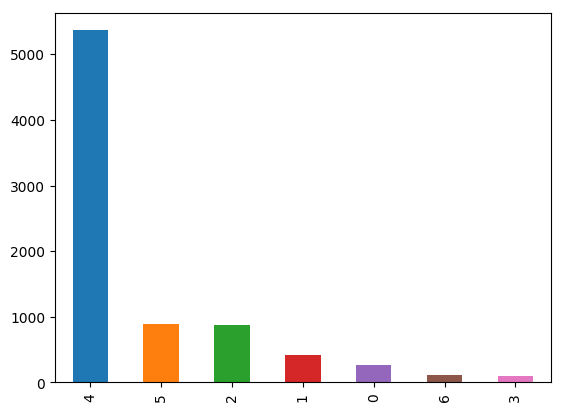

In [28]:
y_train_o.value_counts().plot(kind='bar')